In [1]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Number of words in dictionary:  34417


<ipython-input-2-b739e45643b5>:88: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(corpus_df.Character)


Epoch 1/60
84/84 [==============================] - 23s 254ms/step - loss: 0.5832 - accuracy: 0.5825 - val_loss: 0.5535 - val_accuracy: 0.6345
Epoch 2/60
84/84 [==============================] - 19s 226ms/step - loss: 0.5161 - accuracy: 0.5961 - val_loss: 0.5423 - val_accuracy: 0.6029
Epoch 3/60
84/84 [==============================] - 22s 265ms/step - loss: 0.4324 - accuracy: 0.6259 - val_loss: 0.5682 - val_accuracy: 0.5520
Epoch 4/60
84/84 [==============================] - 20s 236ms/step - loss: 0.3477 - accuracy: 0.6442 - val_loss: 0.6116 - val_accuracy: 0.5183
Epoch 5/60
84/84 [==============================] - 23s 274ms/step - loss: 0.2787 - accuracy: 0.6643 - val_loss: 0.6781 - val_accuracy: 0.5583
Epoch 6/60
84/84 [==============================] - 20s 244ms/step - loss: 0.2337 - accuracy: 0.6778 - val_loss: 0.7394 - val_accuracy: 0.5343
Epoch 7/60
84/84 [==============================] - 22s 260ms/step - loss: 0.2051 - accuracy: 0.6790 - val_loss: 0.8356 - val_accuracy: 0.5461

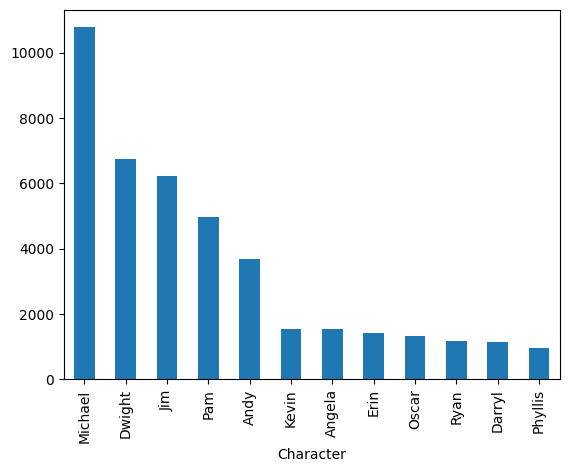

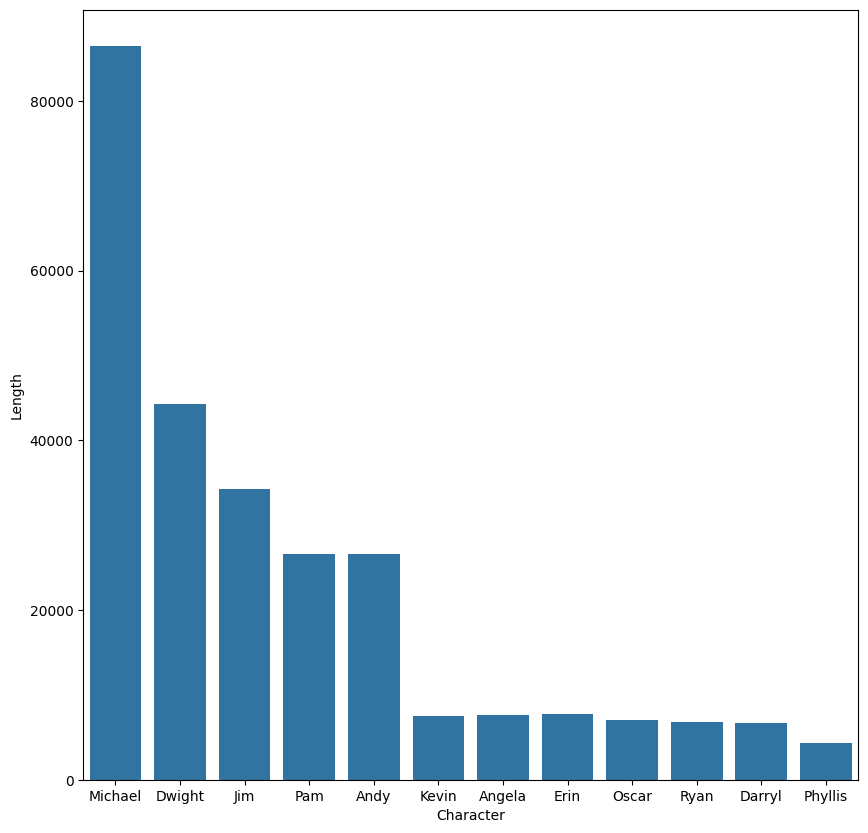

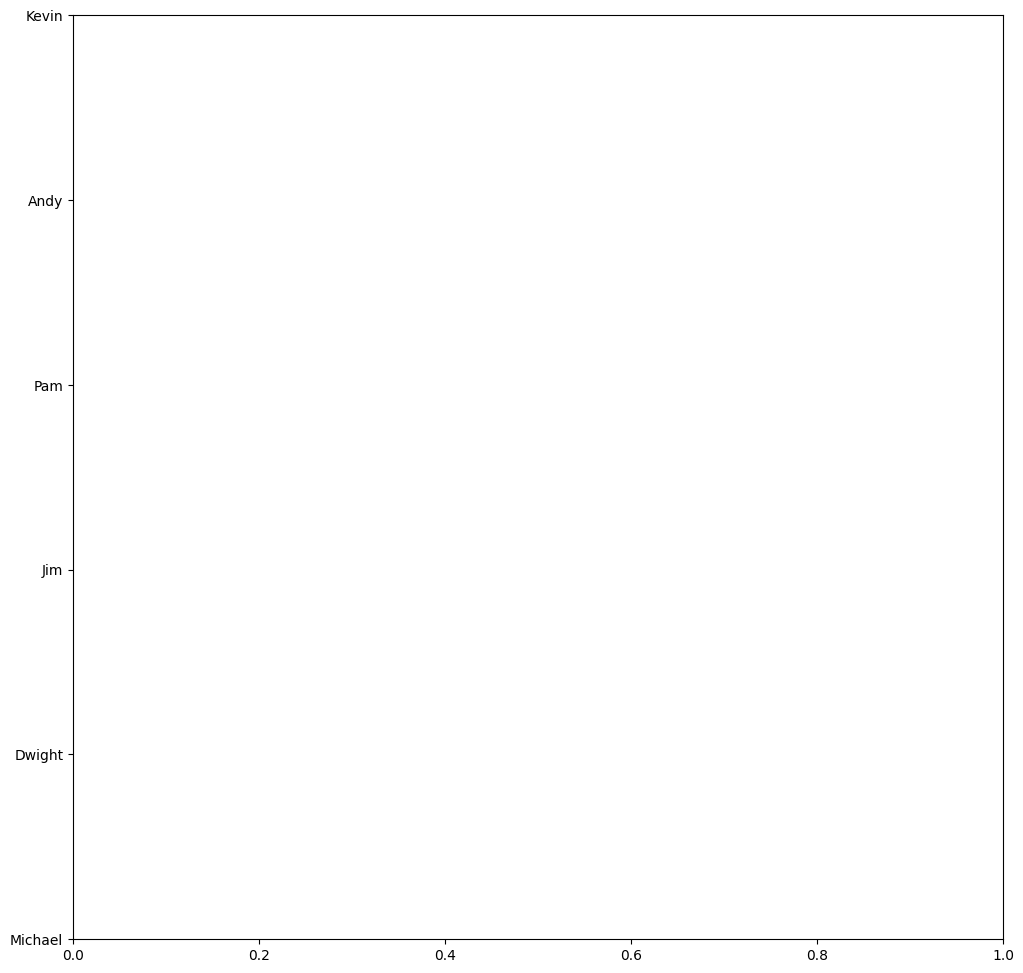

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing data
data1="theoffice.csv"
data2="seinfeld.csv"
dat=data1
df = pd.read_csv(dat)
df.dropna(subset=['Dialogue'], inplace=True)


df["Character"].value_counts().head(12).plot(kind="bar")

def datlistcor_creator(name):
    st = ""
    for i in df["Dialogue"][df["Character"]==name]:
        st = st + i
    return st
#thanks to thebrownviking20 on kaggle for inspiring this proj.

datlistcor_df = pd.DataFrame()
datlistcor_df["Character"] = list(df["Character"].value_counts().head(12).index)

li = []
for i in datlistcor_df["Character"]:
    li.append(datlistcor_creator(i))

datlistcor_df["Dialogues"] = li

datlistcor_df


from sklearn.feature_extraction import text
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

from nltk.tokenize import word_tokenize
def tproc(dialogue):
    dialogue = word_tokenize(dialogue)
    nopunc=[word.lower() for word in dialogue if word not in stop_words]
    nopunc=' '.join(nopunc)
    return [word for word in nopunc.split()]

datlistcor_df["Dialogues"] = datlistcor_df["Dialogues"].apply(lambda x: tproc(x))

datlistcor_df["Length"] = datlistcor_df["Dialogues"].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(ax=ax,y="Length",x="Character",data=datlistcor_df)

import gensim

# word dic mapper
dictionary = gensim.corpora.Dictionary(datlistcor_df["Dialogues"])
print("Number of words in dictionary: ", len(dictionary))

#  datlistcor bow representation for a document just lists the number of times each word occurs in the txt.
datlistcor = [dictionary.doc2bow(bw) for bw in datlistcor_df["Dialogues"]]

# tf-idf model on our datlistcor
tf_idf = gensim.models.TfidfModel(datlistcor)

# similar obj for heatmap
sims = gensim.similarities.Similarity('', tf_idf[datlistcor], num_features=len(dictionary))

# df out of similaritie
sim_list = []
for i in range(12):
    query = dictionary.doc2bow(datlistcor_df["Dialogues"][i])
    query_tf_idf = tf_idf[query]
    sim_list.append(sims[query_tf_idf])
corr_df=pd.DataFrame()
j=0
for i in datlistcor_df["Character"]:
    corr_df[i] = sim_list[j]
    j=j+1


fig, ax = plt.subplots(figsize=(12,12))
# sns.heatmap(corr_df,ax=ax,annot=True)
ax.set_yticklabels(datlistcor_df.Character)
# plt.show()

def ptextor(dialogue):
    nopunc=[word.lower() for word in dialogue if word not in stop_words]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split()]

corpus_df=datlistcor_df
corpus_df['Dialogue_Length'] = corpus_df['Dialogues'].apply(len)
top_10_characters_df = corpus_df.sort_values(by='Dialogue_Length', ascending=False).head(3)
top_10_characters_list = top_10_characters_df['Character'].tolist()
df = df[df['Character'].isin(top_10_characters_list)]
X = df["Dialogue"]
import numpy as np
y = df["Character"]
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
labelencoder_X_1 = LabelEncoder()
y = labelencoder_X_1.fit_transform(y)
y = y.reshape(-1,1)
onehotencoder = OneHotEncoder()
y = onehotencoder.fit_transform(y).toarray()
y = np.delete(y,2,1).astype(int)
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_matrix(X)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
mawords=X.shape[1]
num_classes=y.shape[1]
from keras.models import Sequential
model = Sequential()
from keras.layers import Dense, Activation, Dropout
model.add(Dense(512, input_shape=(mawords,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256, input_shape=(mawords,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(128, input_shape=(mawords,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=60,batch_size=256,validation_data=(X_test, y_test))


In [ ]:
#this is for non nn thing, merging it to ipynb

from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing data
data1="theoffice.csv"
data2="seinfeld.csv"
dat=data1
df = pd.read_csv(dat)
df.dropna(subset=['Dialogue'], inplace=True)


df["Character"].value_counts().head(12).plot(kind="bar")

def datlistcor_creator(name):
    st = ""
    for i in df["Dialogue"][df["Character"]==name]:
        st = st + i
    return st

datlistcor_df = pd.DataFrame()
datlistcor_df["Character"] = list(df["Character"].value_counts().head(12).index)

li = []
for i in datlistcor_df["Character"]:
    li.append(datlistcor_creator(i))

datlistcor_df["Dialogues"] = li

datlistcor_df


from sklearn.feature_extraction import text
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

from nltk.tokenize import word_tokenize
def tproc(dialogue):
    dialogue = word_tokenize(dialogue)
    nopunc=[word.lower() for word in dialogue if word not in stop_words]
    nopunc=' '.join(nopunc)
    return [word for word in nopunc.split()]

datlistcor_df["Dialogues"] = datlistcor_df["Dialogues"].apply(lambda x: tproc(x))

datlistcor_df["Length"] = datlistcor_df["Dialogues"].apply(lambda x: len(x))

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(ax=ax,y="Length",x="Character",data=datlistcor_df)

import gensim

# word dic mapper
dictionary = gensim.corpora.Dictionary(datlistcor_df["Dialogues"])
print("Number of words in dictionary: ", len(dictionary))

#  datlistcor bow representation for a document just lists the number of times each word occurs in the txt.
datlistcor = [dictionary.doc2bow(bw) for bw in datlistcor_df["Dialogues"]]

# tf-idf model on our datlistcor
tf_idf = gensim.models.TfidfModel(datlistcor)

# similar obj for heatmap
sims = gensim.similarities.Similarity('', tf_idf[datlistcor], num_features=len(dictionary))

# df out of similaritie
sim_list = []
for i in range(12):
    query = dictionary.doc2bow(datlistcor_df["Dialogues"][i])
    query_tf_idf = tf_idf[query]
    sim_list.append(sims[query_tf_idf])
corr_df=pd.DataFrame()
j=0
for i in datlistcor_df["Character"]:
    corr_df[i] = sim_list[j]
    j=j+1


fig, ax = plt.subplots(figsize=(12,12))
# sns.heatmap(corr_df,ax=ax,annot=True)
ax.set_yticklabels(datlistcor_df.Character)
# plt.show()

def ptextor(dialogue):
    nopunc=[word.lower() for word in dialogue if word not in stop_words]
    nopunc=''.join(nopunc)
    return [word for word in nopunc.split()]



datlistcor_df['Dialogue_Length'] = datlistcor_df['Dialogues'].apply(len)

# the var name change in order to inc efficiency
top_10_characters_df = datlistcor_df.sort_values(by='Dialogue_Length', ascending=False).head(3)

# top characters
top_10_characters_list = top_10_characters_df['Character'].tolist()
# dialogues of top characters
df = df[df['Character'].isin(top_10_characters_list)]
X = df["Dialogue"]
y = df["Character"]
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer=ptextor).fit(X)
print(len(vectorizer.vocabulary_))
X = vectorizer.transform(X)

# Splitting the data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
# from imblearn.over_sampling import RandomOverSampler
# oversample = RandomOverSampler(random_state=42)
# X_train, y_train = oversample.fit_resample(X_train, y_train)
from imblearn.under_sampling import RandomUnderSampler
undersample=RandomUnderSampler(random_state=42)
X_train, y_train = undersample.fit_resample(X_train, y_train)

from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.ensemble import VotingClassifier as VC
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, alpha=0.2, solver='adam', verbose=10, random_state=42, tol=1e-4)
mnb = MNB(alpha=10)
lor = LR(random_state=101)
rf = RFC(n_estimators=80, criterion="entropy", random_state=42, n_jobs=-1)
vcf = VC(estimators=[('mlp',mlp)], voting='hard')
# change rfc for other models when testing them out
rf.fit(X_train,y_train)
predict = rf.predict(X_test)


# classif report
print(confusion_matrix(y_test, predict))
print('\n')
print(classification_report(y_test, predict))
def predic(s):
    print("Before Vectorisation:-")
    print(s)
    s = vectorizer.transform(s)
    print("After Vectorisation:-")
    print(s)
    ans = rf.predict(s)
    print(ans)
print("Jan is about to have a baby with a sperm donor. And, Michael is preparing for the birth of a watermelon with Dwight. Now, this baby will be related to Michael through delusion.")
predic(["Jan is about to have a baby with a sperm donor. And, Michael is preparing for the birth of a watermelon with Dwight. Now, this baby will be related to Michael through delusion."])


: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
epochs = range(1, 61)
loss = [0.9568, 0.6731, 0.6504, 0.5948, 0.5091, 0.4433, 0.3915, 0.3679, 0.3412, 0.3200, 0.3088, 0.3031, 0.2916, 0.2844, 0.2780, 0.2704, 0.2684, 0.2603, 0.2588, 0.2566, 0.2558, 0.2530, 0.2516, 0.2468, 0.2528, 0.2479, 0.2461, 0.2445, 0.2392, 0.2434, 0.2426, 0.2403, 0.2416, 0.2390, 0.2420, 0.2408, 0.2375, 0.2359, 0.2393, 0.2353, 0.2372, 0.2366, 0.2346, 0.2332, 0.2349, 0.2348, 0.2368, 0.2329, 0.2315, 0.2366, 0.2335, 0.2336, 0.2330, 0.2330, 0.2313, 0.2321, 0.2324, 0.2341, 0.2313, 0.2294]
accuracy = [0.5766, 0.5766, 0.5860, 0.6587, 0.7486, 0.7781, 0.8069, 0.8097, 0.8270, 0.8233, 0.8307, 0.8294, 0.8356, 0.8323, 0.8356, 0.8360, 0.8335, 0.8356, 0.8381, 0.8372, 0.8348, 0.8372, 0.8422, 0.8364, 0.8372, 0.8393, 0.8397, 0.8401, 0.8385, 0.8422, 0.8381, 0.8389, 0.8422, 0.8405, 0.8409, 0.8389, 0.8405, 0.8389, 0.8417, 0.8381, 0.8389, 0.8434, 0.8389, 0.8422, 0.8422, 0.8409, 0.8389, 0.8413, 0.8385, 0.8376, 0.8426, 0.8417]
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training Loss vs. Epoch')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.tight_layout()
plt.show()